In [1]:
import numpy as np
import matplotlib.pyplot as plt

from acrolib.plotting import plot_reference_frame, get_default_axes3d
from acrolib.geometry import rotation_matrix_to_rpy, rot_x, rot_y, rot_z

from acrobotics.path.util import create_grid

from pyquaternion import Quaternion



In [2]:
# => use scipy docs https://docs.scipy.org/doc/scipy-1.3.1/reference/index.html
import scipy
scipy.__version__

'1.3.1'

# Sanity check scipy implementations

Compare the scipy functions with some quick manual implementations to make sure we understand what is going on.

## Manual implementations

In [3]:
# Angle axis / rotation vector / exponential coordinates conversions
def skew(v):
    return np.array(
        [[0., -v[2], v[1]],
         [v[2], 0., -v[0]],
         [-v[1], v[0], 0.]]
    )

def rodrigues(axis, angle):
    w = skew(axis)
    return np.eye(3) + np.sin(angle) * w + (1 - np.cos(angle)) * (w @ w)

def my_rotvec_to_mat(s):
    angle = np.linalg.norm(s)
    axis = np.array(s) / angle
    return rodrigues(axis, angle)

# Intrinsic XYZ rotation angles conversions
def my_xyz_intrinsic_to_mat(angles):
    return rot_x(angles[0]) @ rot_y(angles[1]) @ rot_z(angles[2])

def my_mat_to_xyz_intrinsic(R):
    r11, r12, r13 = R[0]
    _, _, r23 = R[1]
    _, _, r33 = R[2]

    r_x = np.arctan2(-r23, r33)
    r_y = np.arctan2(r13, np.sqrt(r11 ** 2 + r12 ** 2))
    r_z = np.arctan2(-r12, r11)

    return [r_x, r_y, r_z]

## Scipy implementations

In [4]:
from scipy.spatial.transform import Rotation

def rotvec_to_mat(v):
    return Rotation.from_rotvec(v).as_dcm()

def mat_to_rotvec(mat):
    r = Rotation.from_dcm(mat)
    return r.as_rotvec()

def xyz_intrinsic_to_mat(v):
    return Rotation.from_euler("XYZ", v).as_dcm()

def mat_to_xyz_intrinsic(mat):
    r = Rotation.from_dcm(mat)
    return r.as_euler("XYZ")

## Compare the implementations

In [5]:
def compare(f1, f2, shape, N=1000, TOL=1e-14):
    for _ in range(N):
        s = np.random.rand(*shape)
        error = np.max(np.abs(f1(s) - f2(s)))
        if error > TOL:
            raise AssertionError(f"Error is {error} for input {s}")

def compare_with_valid_rotmat(f1, f2, N=1000, TOL=1e-14):
    for _ in range(N):
        r = Quaternion.random().rotation_matrix
        error = np.max(np.abs(f1(r) - f2(r)))
        if error > TOL:
            raise AssertionError(f"Error is {error} for input {r}")

In [6]:
compare(my_rotvec_to_mat, rotvec_to_mat, (3,))
compare(my_xyz_intrinsic_to_mat, xyz_intrinsic_to_mat, (3,))

compare_with_valid_rotmat(my_mat_to_xyz_intrinsic, mat_to_xyz_intrinsic)

# Find a test case

In [7]:
def decide_xyz_rot_angles(rotation_matrix, lower, upper):
    v = mat_to_xyz_intrinsic(rotation_matrix)
    return np.all(np.logical_and(v >= lower, v <= upper))

def decide_rotvec(rotation_matrix, lower, upper):
    v = mat_to_rotvec(rotation_matrix)
    return np.all(np.logical_and(v >= lower, v <= upper))

In [8]:
l, u = np.array(3 * [-0.5]), np.array(3 * [0.5])
dxyz = lambda r: decide_xyz_rot_angles(r, l, u)
drv = lambda r: decide_rotvec(r, l, u)

## Cases starting from xyz range

In [17]:
angle_range = np.linspace(-0.49, 0.49, 3)
samples = create_grid(3 * [angle_range])

for s in samples:
    r = xyz_intrinsic_to_mat(s)
    q = Quaternion(matrix=r)
    s1, s2 = dxyz(r), drv(r)
    assert(s1)
    if s1 and not s2:
        #print(s)
        print("{}, {}, {}, {}".format(q.x, q.y, q.z, q.w))

-0.1712092272140422, -0.2853625129991958, -0.1712092272140422, 0.9273311367620117
-0.28536251299919585, -0.17120922721404216, 0.28536251299919585, 0.8987902273981057
0.28536251299919585, -0.17120922721404216, -0.28536251299919585, 0.8987902273981057
0.1712092272140422, -0.2853625129991958, 0.1712092272140422, 0.9273311367620117
-0.28536251299919585, 0.17120922721404216, -0.28536251299919585, 0.8987902273981057
-0.1712092272140422, 0.2853625129991958, 0.1712092272140422, 0.9273311367620117
0.1712092272140422, 0.2853625129991958, -0.1712092272140422, 0.9273311367620117
0.28536251299919585, 0.17120922721404216, 0.28536251299919585, 0.8987902273981057


## Cases starting from rotvec range

In [18]:
# angle_range = np.linspace(-0.5, 0.5, 5)
# samples = create_grid(3 * [angle_range])

for s in samples:
    r = rotvec_to_mat(s)
    q = Quaternion(matrix=r)
    s1, s2 = dxyz(r), drv(r)
    #print(s1, s2)
    if s2 and not s1:
        #print(s)
        print("{}, {}, {}, {}".format(q.x, q.y, q.z, q.w))
#     assert(s2)
#     if not s1:
#         print(s)

-0.23771285949073287, -0.23771285949073287, -0.23771285949073287, 0.911305541132181
-0.2401272988734743, -0.2401272988734743, 0.0, 0.9405731022474852
-0.23771285949073287, -0.23771285949073287, 0.23771285949073287, 0.911305541132181
0.0, -0.24012729887347428, -0.24012729887347428, 0.9405731022474851
0.0, -0.24012729887347428, 0.24012729887347428, 0.9405731022474851
0.23771285949073287, -0.23771285949073287, -0.23771285949073287, 0.911305541132181
0.2401272988734743, -0.2401272988734743, 0.0, 0.9405731022474852
0.23771285949073287, -0.23771285949073287, 0.23771285949073287, 0.911305541132181
-0.23771285949073287, 0.23771285949073287, -0.23771285949073287, 0.911305541132181
-0.2401272988734743, 0.2401272988734743, 0.0, 0.9405731022474852
-0.23771285949073287, 0.23771285949073287, 0.23771285949073287, 0.911305541132181
0.0, 0.24012729887347428, -0.24012729887347428, 0.9405731022474851
0.0, 0.24012729887347428, 0.24012729887347428, 0.9405731022474851
0.23771285949073287, 0.2377128594907328

## Try samples on a grid

In [48]:
N = 5
dx = 0.6; dy = 0.1
rx = np.linspace(-dx / 2, dx / 2, N)
ry = np.linspace(-dy / 2, dy / 2, N)
samples = create_grid([rx, 0.5, ry])
# samples

# Euler angles

In [5]:
euler_samples = []
for s in samples:
    euler_samples += [rot_x(s[0]) @ rot_y(s[1]) @ rot_z(s[2])]
    
aa_samples = []
for s in samples:
    # convert to rotation matrix
    angle = np.linalg.norm(s)
    axis = np.array(s) / angle
    
    #q = Quaternion(axis=axis, angle=angle)
    
    #aa_samples += [q.rotation_matrix]
    
    aa_samples += [rodrigues(axis, angle)]

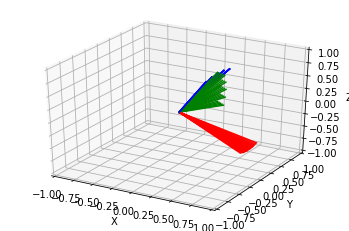

In [6]:
fig, ax = get_default_axes3d()
tf = np.eye(4)
for s in euler_samples:
    tf[:3, :3] = s
    plot_reference_frame(ax, tf=tf, arrow_length=1.0)

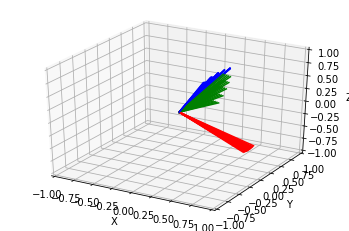

In [7]:
fig, ax = get_default_axes3d()
tf = np.eye(4)
for s in aa_samples:
    tf[:3, :3] = s
    plot_reference_frame(ax, tf=tf, arrow_length=1.0)

In [8]:
diffs = []
for e, a in zip(euler_samples, aa_samples):
    diffs.append(np.sum(e - a))

In [9]:
large_diff_s = samples[np.argmax(diffs)]

In [10]:
s = large_diff_s
rot_x(s[0]) @ rot_y(s[1]) @ rot_z(s[2])

array([[ 0.87648581,  0.04386085,  0.47942554],
       [ 0.09375595,  0.96122361, -0.25934338],
       [-0.47221017,  0.27225979,  0.83838664]])

In [22]:
s = large_diff_s
angle = np.linalg.norm(s)
axis = np.array(s) / angle

#q = Quaternion(axis=axis, angle=angle)

#aa_samples += [q.rotation_matrix]

rodrigues(axis, angle)

array([[ 0.8773125 ,  0.12007798,  0.46465478],
       [ 0.02568935,  0.95505507, -0.29531316],
       [-0.47923151,  0.27101861,  0.83479703]])